In [2]:
import community as community_louvain
import networkx as nx
from collections import defaultdict
import db_connection
import db_methods
import community_detection
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [3]:
print("\nConnection")
collection = db_connection.connect_to_mongodb(collection_name="Videos Data")


Connection
Connected to MongoDB at localhost:27017, Database: evollistable, Collection: Videos Data


In [4]:
print("\nDB query")
channel_categories = db_methods.retrieve_categories_from_mongodb(collection)


DB query


In [5]:
channel_categories.keys().__len__()

173574

In [6]:
def compute_co_occurrence(channel_categories_dict):
    """
    Computes the co-occurrence matrix for categories across all channels.
    
    Args:
    - channel_categories_dict: A dictionary where keys are channel_ids and values are lists of categories.
    
    Returns:
    - global_co_occurrence: A dictionary where keys are pairs of categories and values are their co-occurrence count.
    """
    global_co_occurrence = defaultdict(int)
    
    # Iterate through each channel and their associated categories
    for channel_id, categories in channel_categories_dict.items():
        for i in range(len(categories)):
            for j in range(i + 1, len(categories)):
                cat_1 = categories[i]
                cat_2 = categories[j]
                if len(cat_1)==0 or len(cat_2)==0:
                    continue
                # Increment the co-occurrence count for each category pair
                global_co_occurrence[(cat_1, cat_2)] += 1
                #global_co_occurrence[(cat_2, cat_1)] += 1  # Make the relationship undirected
                
    return global_co_occurrence

In [7]:
print("\nCo-occurrence matrix")
co_occurrence_matrix = compute_co_occurrence(channel_categories)    


Co-occurrence matrix


In [8]:
co_occurrence_matrix

defaultdict(int,
            {('Entertainment', 'Nonprofits & Activism'): 3105,
             ('Entertainment', 'Travel & Events'): 6501,
             ('Entertainment', 'People & Blogs'): 21616,
             ('Entertainment', 'Science & Technology'): 5559,
             ('Entertainment', 'News & Politics'): 5422,
             ('Entertainment', 'Sports'): 6119,
             ('Entertainment', 'Film & Animation'): 12497,
             ('Entertainment', 'Education'): 9813,
             ('Entertainment', 'Comedy'): 12602,
             ('Entertainment', 'Howto & Style'): 9805,
             ('Nonprofits & Activism', 'Travel & Events'): 1660,
             ('Nonprofits & Activism', 'People & Blogs'): 2912,
             ('Nonprofits & Activism', 'Science & Technology'): 1655,
             ('Nonprofits & Activism', 'News & Politics'): 1910,
             ('Nonprofits & Activism', 'Sports'): 1447,
             ('Nonprofits & Activism', 'Film & Animation'): 2004,
             ('Nonprofits & Activism', 

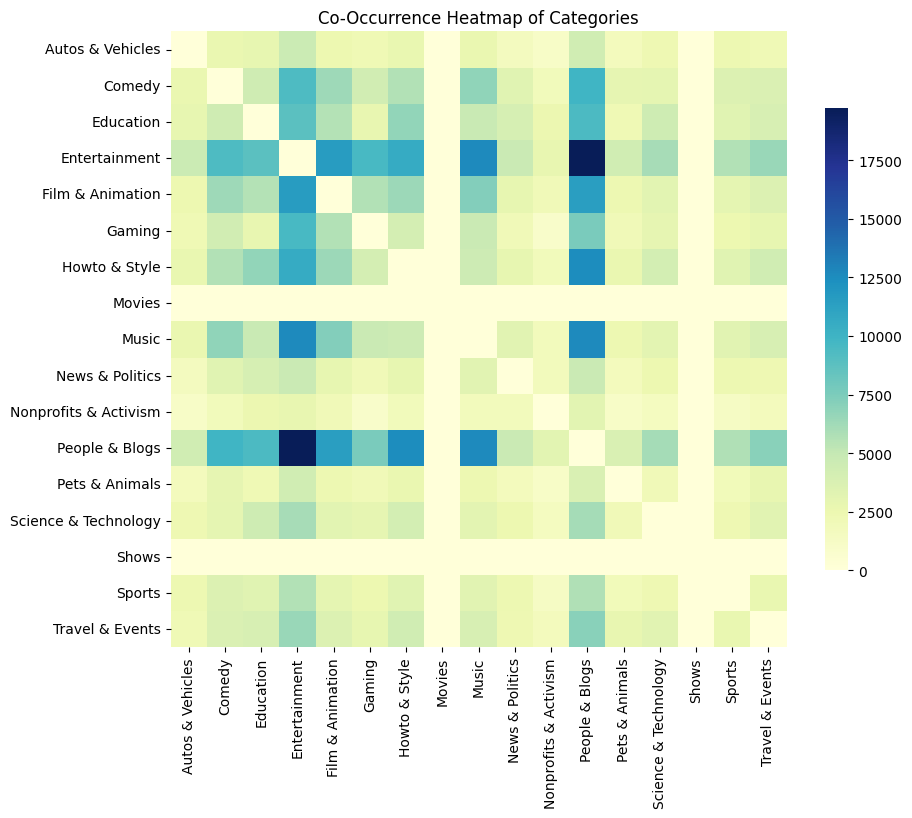

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_co_occurrence_heatmap(co_occurrence_matrix):
    # Extract all unique categories from the co-occurrence dictionary
    categories = sorted(set([cat for pair in co_occurrence_matrix.keys() for cat in pair]))
    
    # Initialize a DataFrame with zeros for all category pairs
    df = pd.DataFrame(0, index=categories, columns=categories)
    
    # Fill in the DataFrame with the co-occurrence counts
    for (cat1, cat2), count in co_occurrence_matrix.items():
        df.loc[cat1, cat2] = count
        df.loc[cat2, cat1] = count  # Ensure symmetry
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=False, cmap="YlGnBu", square=True, cbar_kws={"shrink": 0.75})
    plt.title("Co-Occurrence Heatmap of Categories")
    plt.show()

plot_co_occurrence_heatmap(co_occurrence_matrix)


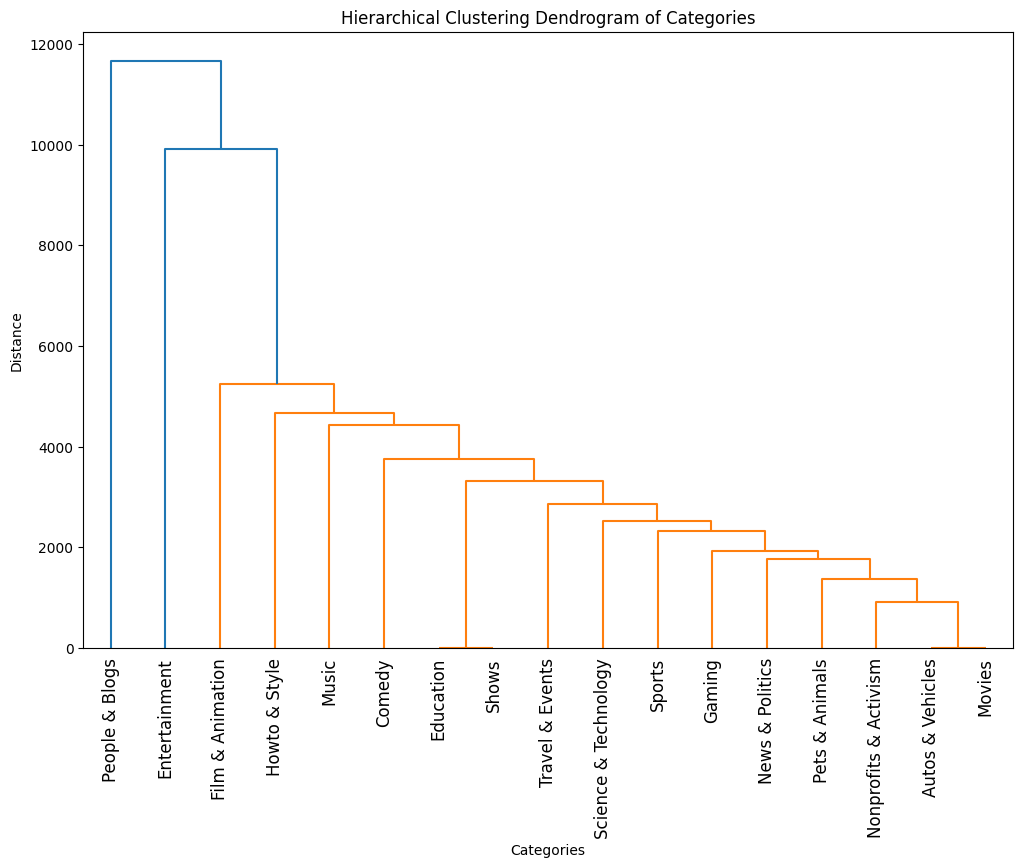

In [10]:
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform


def plot_co_occurrence_dendrogram(co_occurrence_matrix):
    # Convert to a square matrix for hierarchical clustering
    categories = sorted(set([cat for pair in co_occurrence_matrix.keys() for cat in pair]))
    matrix = np.zeros((len(categories), len(categories)))
    for (cat1, cat2), count in co_occurrence_matrix.items():
        #if count>700:
            i, j = categories.index(cat1), categories.index(cat2)
            matrix[i, j] = count
            matrix[j, i] = count  # Ensure symmetry

    # Convert the full distance matrix to a condensed one
    condensed_matrix = squareform(matrix)

    # Perform hierarchical clustering
    linkage_matrix = linkage(condensed_matrix, method='ward')

    # Plot dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, labels=categories, leaf_rotation=90)
    plt.title("Hierarchical Clustering Dendrogram of Categories")
    plt.xlabel("Categories")
    plt.ylabel("Distance")
    plt.show()

plot_co_occurrence_dendrogram(co_occurrence_matrix)

In [11]:
def plot_co_occurrence_network(co_occurrence_matrix):
    """
    Visualizes the co-occurrence network of categories. Categories that appear together often
    will be positioned closer together, and their co-occurrence is represented by edges.
    
    Args:
    - co_occurrence_matrix: A dictionary where the keys are pairs of categories and the values
                             are the number of times those categories co-occur.
    """
    # Create a graph from the co-occurrence matrix
    G = nx.Graph()
    
    # Add edges with weights from the co-occurrence matrix
    for (cat1, cat2), count in co_occurrence_matrix.items():
        if count > 5000:  # Ignore pairs with low co-occurrence counts
            G.add_edge(cat1, cat2, weight=count)
    
    # Use a spring layout to arrange the nodes. This layout places connected nodes closer to each other.
    pos = nx.spring_layout(G, k=0.18,weight='weight', iterations=1000)
    
    # Prepare the plot
    plt.figure(figsize=(12, 8))
    
    # Draw the nodes with color based on their degree (how many connections they have)
    node_size = [v * 100 for v in dict(G.degree()).values()]  # Node size based on degree
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color="skyblue", alpha=0.7)
    
    # Draw edges with thickness based on the weight of the co-occurrence
    edge_width = [0.5 for u, v, d in G.edges(data=True)]  # Scale edge width by weight
    nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.5, edge_color="gray")
    
    # Draw labels for the categories
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")
    
    # Title and show plot
    plt.title("Co-Occurrence Network of Categories")
    plt.axis('off')  # Turn off the axis
    plt.show()



Co-occurrence network


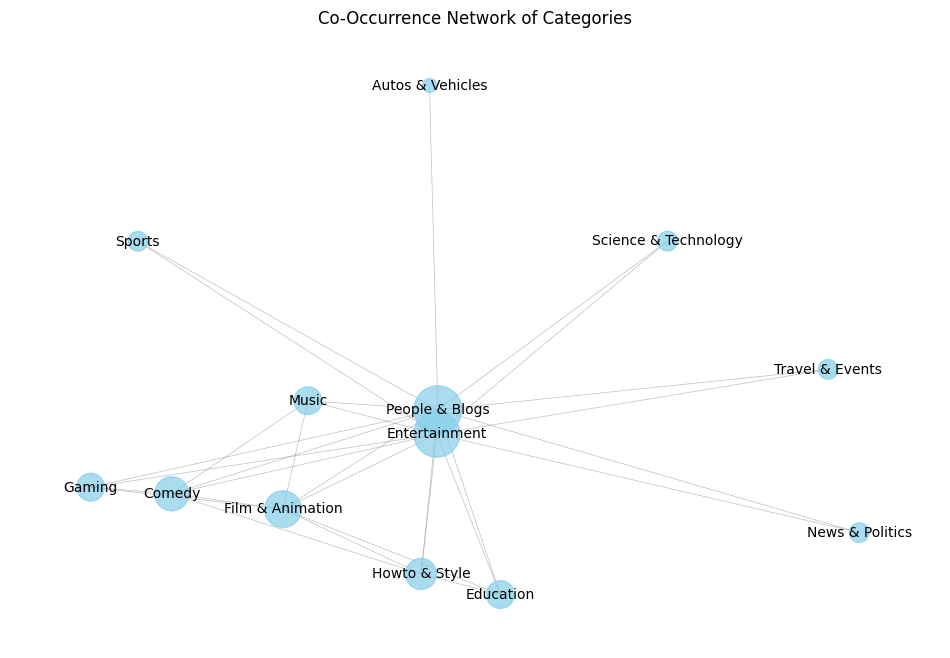

In [12]:
print("\nCo-occurrence network")
plot_co_occurrence_network(co_occurrence_matrix)

Observations and Insights:
Core vs. Peripheral Categories:

Central Nodes: Categories like People & Blogs, Entertainment, Comedy, and Film & Animation appear centrally positioned with multiple connections, suggesting they frequently co-occur with various other categories. These could be highly versatile categories that often overlap with others.
Peripheral Nodes: Categories like Autos & Vehicles, News & Politics, Pets & Animals, and Sports appear on the outskirts with fewer connections. This suggests these categories may be more specialized or niche in nature, with fewer associations with other categories.
Potential Clustering:

You can observe natural groupings in the layout. For example, People & Blogs and Entertainment are connected closely with Comedy, Film & Animation, and Music, indicating a possible cluster of lifestyle and entertainment-related categories. Meanwhile, Education and Science & Technology also connect, hinting at an informative or educational grouping.

Categories like People & Blogs and Entertainment appear to have connections to a wide variety of other nodes, which could mean that they act as bridge categories in your dataset, connecting otherwise unrelated topics. This could be due to users' diverse interests, where general categories like “People & Blogs” cover broad, popular topics.

How one can choose the overall category of a channel? Node centrality?

In [13]:
import networkx as nx
import pandas as pd
import plotly.graph_objects as go

def plot_interactive_co_occurrence_network(co_occurrence_matrix):
    # Create a graph from the co-occurrence matrix
    G = nx.Graph()
    for (cat1, cat2), count in co_occurrence_matrix.items():
        if count>5000:
            G.add_edge(cat1, cat2, weight=count)
    
    # Calculate positions using spring layout
    pos = nx.spring_layout(G, k=0.17, weight='weight', iterations=1000)
    
    # Define node sizes based on the degree (number of connections)
    node_sizes = [G.degree(node) * 20 for node in G.nodes()]
    
    # Set node colors based on communities
    #communities = nx.community.greedy_modularity_communities(G)
    #print(communities)
    # Louvain's good but results may vary
    community_map = community_louvain.best_partition(G, resolution=1.2)
    print(community_map)
    #community_map = {node: i for i, community in enumerate(communities) for node in community}
    node_colors = [community_map[node] for node in G.nodes()]
    
    # Create Plotly edge traces
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )
    
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += (x0, x1, None)
        edge_trace['y'] += (y0, y1, None)
    
    # Create Plotly node traces
    node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers+text',
        textposition="top center",
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            color=[],
            size=node_sizes,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
        )
    )
    
    for node in G.nodes():
        x, y = pos[node]
        node_trace['x'] += (x,)
        node_trace['y'] += (y,)
        
        # Append node information for hover text
        node_trace['text'] += (f'{node}<br># of Connections: {G.degree(node)}',)
        node_trace['marker']['color'] += (community_map[node],)
    
    # Create the Plotly figure
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Interactive Co-Occurrence Network of Categories',
                        titlefont_size=16,
                        showlegend=False,
                        width=1200,
                        height=600,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=40),
                        annotations=[dict(
                            text="Hover over nodes to see details",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002 )],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    
    # Show the plot
    fig.show()

# Example usage with your co_occurrence_matrix dictionary
# co_occurrence_matrix = {('Category1', 'Category2'): count, ... }
plot_interactive_co_occurrence_network(co_occurrence_matrix)


{'Entertainment': 1, 'Travel & Events': 1, 'People & Blogs': 1, 'Science & Technology': 1, 'News & Politics': 1, 'Sports': 1, 'Film & Animation': 2, 'Education': 0, 'Comedy': 2, 'Howto & Style': 0, 'Music': 2, 'Gaming': 2, 'Autos & Vehicles': 1}


How do these clusters compare with each other in terms of performance?

What's the typical evolution of views for each cluster (time series)?

Diversity vs niche categories?

+if we have missing categories, we use nlp to predict the category of the video 

+Define a metric that assesses the diversity of a channel and fit some kind of ditribution (ex: gaussian). Compare the performance of the three regions (less than -2*sigma, confidence interval, more than 2*sigma) 

+Define a metric that assesses the performance of a channel.

+Compare the performances of diverse channels vs non diverse. Is there some correlation? Can we verify causality? Is there a tipping point where diversity becomes a drawback?

+The typical temporal evolution in performance of a video published by a diverse channel vs non diverse one.

+Correlation, variance, statistical tests....

+ Prediction of something

Comparison between the typical evolution of a channel of the cluster (gaming, music...) with education, howto&style..

# Design of a Channel Diversity Metric: A Quantitative Approach to Content Diversity

We want to evaluate the diversity of a channel based not only on the distribution of categories it publishes but also on the relatedness of those categories. Specifically, a channel that publishes content in categories that rarely co-occur (categories that are less related) should be considered more diverse than one that publishes content in closely related categories.

### i. Entropy: Measuring Category Distribution

The entropy term captures the **spread** of content across different categories in a channel. If a channel focuses on a narrow set of categories, entropy will be low, while a more balanced distribution of content across categories will yield higher entropy. Formally, entropy is calculated as:

$$
H = - \sum_{i=1}^{n} p_i \log(p_i)
$$

where $(p_i)$ is the proportion of content in category $(i)$ (estimated directly from the channel's category distribution), and $(n)$ is the total number of unique categories within the channel. A higher value of entropy indicates that the channel is more diverse in terms of the variety of topics it covers.

### ii. Normalized Mutual Information (NMI): Adjusting for Category Relationships

While entropy accounts for the spread of content, it does not capture how the categories are related. Channels that use categories with **high co-occurrence** may appear diverse at first glance, but in reality, they may be focusing on overlapping topics. To account for this, we incorporate **Normalized Mutual Information (NMI)**.

The NMI between two categories $(i)$ and $(j)$ is given by:

$$
\text{NMI}(i,j) = \frac{I(i,j)}{\max(H(i), H(j))}
$$

where $(I(i,j))$ is the **mutual information** between categories $(i)$ and $(j)$, and $(H(i))$, $(H(j))$ are the individual entropies of the categories. 

The mutual information is computed using the global co-occurrence matrix of categories across all channels:

$$
I(i,j) = p_{ij} \log \left( \frac{p_{ij}}{p_i^{\text{global}} p_j^{\text{global}}} \right)
$$

where:
- $(p_{ij})$ is the probability of categories $(i)$ and $(j)$ co-occurring across all channels.
- $(p_i^{\text{global}})$ and $(p_j^{\text{global}})$ are the global marginal probabilities of categories $(i)$ and $(j)$, respectively.

If two categories often co-occur, their NMI will be high, suggesting they are not independent, and thus the diversity score is penalized for such overlap.

### iii. The Full Diversity Metric

The final **Channel Diversity Metric** is computed as:

$$
\text{Channel Diversity} = \frac{- \sum_{i=1}^{n} p_i \log(p_i) \cdot (1 - \text{NMI}(i,j))}{\log(n)}
$$

This formula combines the entropy term, which encourages a broad distribution of categories, with the NMI adjustment, which penalizes the use of highly related categories. The division by $(log(n))$ normalizes the score, ensuring comparability across channels with different numbers of categories.

In [14]:
from collections import Counter
from math import log2, sqrt

def calculate_diversity(channel_cats, co_matrix, unique_categories):
    """
    Calculate the diversity score of a channel based on the co-occurrence matrix and categories used by the channel.
    
    Args:
    - channel_cats: List of categories for the given channel (with redundancy).
    - co_matrix: The global co-occurrence matrix as a dictionary.
    - unique_categories: List of all unique categories globally.
    
    Returns:
    - Diversity score for the channel.
    """
    
    # Step 1: Calculate global probabilities
    total_co = sum(co_matrix.values())
    p_ij = {}
    p_global = {}
    
    # Compute global marginal probabilities and joint probabilities
    for cat in unique_categories:
        p_global[cat] = sum(co_matrix.get((cat, other), 0) for other in unique_categories) / total_co
    
    for (cat1, cat2), co_count in co_matrix.items():
        p_ij[(cat1, cat2)] = co_count / total_co

    # Step 2: Channel-specific calculations
    n = len(set(channel_cats))
    if n <= 1:
        return 0  # If only one unique category, diversity is zero
    
    # Channel category counts (with redundancy)
    total_vids = len(channel_cats)
    p_channel = Counter(channel_cats)
    p_i = {cat: p_channel[cat] / total_vids for cat in p_channel}
    
    # Step 3: Calculate NMI for categories within the channel
    def nmi(cat1, cat2):
        if cat1 == cat2:
            return 1.0
        joint_p = p_ij.get((cat1, cat2), 0)
        if joint_p == 0:
            return 0
        mi = joint_p * log2(joint_p / (p_global[cat1] * p_global[cat2])) if (p_global[cat1] * p_global[cat2]) > 0 else 0
        h1 = -p_global[cat1] * log2(p_global[cat1]) if p_global[cat1] > 0 else 0
        h2 = -p_global[cat2] * log2(p_global[cat2]) if p_global[cat2] > 0 else 0
        return mi / sqrt(h1 * h2) if h1 * h2 > 0 else 0
    
    # Step 4: Calculate the diversity score
    diversity = sum(
        -p_i[cat1] * log2(p_i[cat1]) * (1 - nmi(cat1, cat2))
        for cat1 in p_i
        for cat2 in p_i
        if cat1 != cat2
    )
    
    # Normalize by log(n) to ensure scores are bounded
    return diversity / log2(n) if n > 1 else 0

# 1. Testing the Coherence of the Channel Diversity Metric

Before applying the Channel Diversity Metric on real-world data, we first want to verify its coherence by testing it on a few example channels. These examples are chosen to represent different types of content diversity, and we expect the metric to rank them accordingly based on the diversity of their categories.

The example channels are :
**Gaming-focused**, **Diverse-related**, **Diverse-independent** and **Comedy-only**

The expected ranking of the channels in terms of diversity is:

1. **Diverse-independent**: Highest diversity (varied, unrelated categories).
2. **Diverse-related**: Moderate diversity (some overlap between categories).
3. **Gaming-focused**: Lower diversity (dominant "Gaming" category with some overlap).
4. **Comedy-only**: Lowest diversity (single category).

In [15]:
# Test the coherence of our channel diversity metric
channels = {
    "Gaming-focused": ['Gaming', 'Gaming', 'Gaming', 'Gaming','Gaming', 'Music'],
    "Diverse-related": ['Music', 'Music', 'Film & Animation', 'Film & Animation', 'Comedy'],
    "Diverse-independent": ['News & Politics', 'Music', 'Autos & Vehicles', 'Science & Technology'],
    "Comedy-only": ['Comedy', 'Comedy', 'Comedy', 'Comedy']
}
all_categories = ['Comedy', 'Gaming', 'News & Politics', 'Music', 'Autos & Vehicles', 'Science & Technology' , 'Film & Animation']

# Calculate diversity scores for each channel
results = {name: calculate_diversity(cats, co_occurrence_matrix, all_categories) for name, cats in channels.items()}

# Convert results into a pandas DataFrame for better presentation
df_results = pd.DataFrame(list(results.items()), columns=["Channel", "Diversity Score"])

# Sort by Diversity Score to show the ranking
df_results = df_results.sort_values(by="Diversity Score", ascending=False).reset_index(drop=True)

# Display the results in a clean table format
df_results

,Channel,Diversity Score
0,Diverse-independent,2.781013
1,Diverse-related,1.634944
2,Gaming-focused,0.587314
3,Comedy-only,0.000000


**The results seem to be coherent with our expectations! Nice!**

# 2. Application on real channel data

In [16]:
# Channel_data retrieval
channel_data, all_categories = db_methods.retrieve_categories_with_redundancy(collection)

In [17]:
# Compute the diversity score for each one of our channels
diversity_scores_distribution = {channel_id: calculate_diversity(cats, co_occurrence_matrix,all_categories) for channel_id, cats in channel_data.items()}

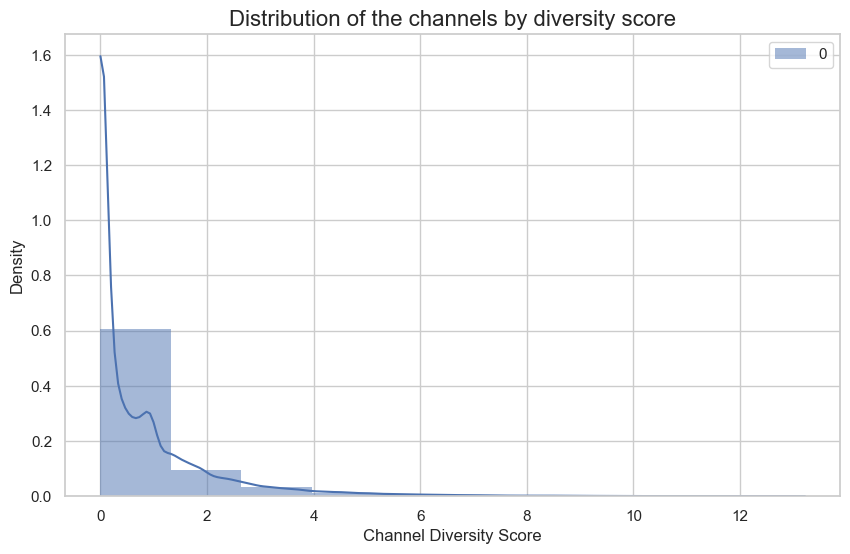

In [18]:
# Create a seaborn style plot for better aesthetics
sns.set(style="whitegrid")

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(diversity_scores_distribution.values(), kde=True, bins=10, color='skyblue', stat='density', linewidth=0)

# Adding labels and title
plt.title("Distribution of the channels by diversity score", fontsize=16)
plt.xlabel("Channel Diversity Score", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Show the plot
plt.show()


From the histogram of channel frequencies and their corresponding diversity scores, we observe that several potential generative laws could explain the observed distribution. The distribution could follow one of the following forms:

1. **Exponential Distribution**: The probability density function (PDF) is given by:

   $$
   f(x|\lambda) = \lambda e^{-\lambda x}, \quad x \geq 0
   $$

2. **Truncated Normal Distribution**: A normal distribution restricted to a specific range, typically used when data is confined within certain bounds. The truncated normal PDF is:

   $$
   f(x|\mu, \sigma, a, b) = \frac{\phi\left(\frac{x - \mu}{\sigma}\right)}{\sigma[\Phi\left(\frac{b - \mu}{\sigma}\right) - \Phi\left(\frac{a - \mu}{\sigma}\right)]}, \quad a \leq x \leq b
   $$

   where $\phi$ is the standard normal PDF and $\Phi$ is the cumulative distribution function (CDF).

3. **Gamma Distribution**:

   $$
   f(x|\alpha, \beta) = \frac{x^{\alpha-1} e^{-x/\beta}}{\beta^\alpha \Gamma(\alpha)}, \quad x \geq 0
   $$

4. **Beta Distribution**:

   $$
   f(x|\alpha, \beta) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}, \quad 0 \leq x \leq 1
   $$

To determine which of these distributions is most plausible for our diversity score data, we proceed by analyzing their goodness of fit. The first step in this process is to visualize the data against the theoretical distribution using a **Quantile-Quantile (QQ) plot**: A QQ plot compares the quantiles of the empirical data against the quantiles of a given theoretical distribution. If the data follows the proposed distribution, the points in the QQ plot will lie approximately on a straight line.

C:\Users\haoul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning:

invalid value encountered in sqrt



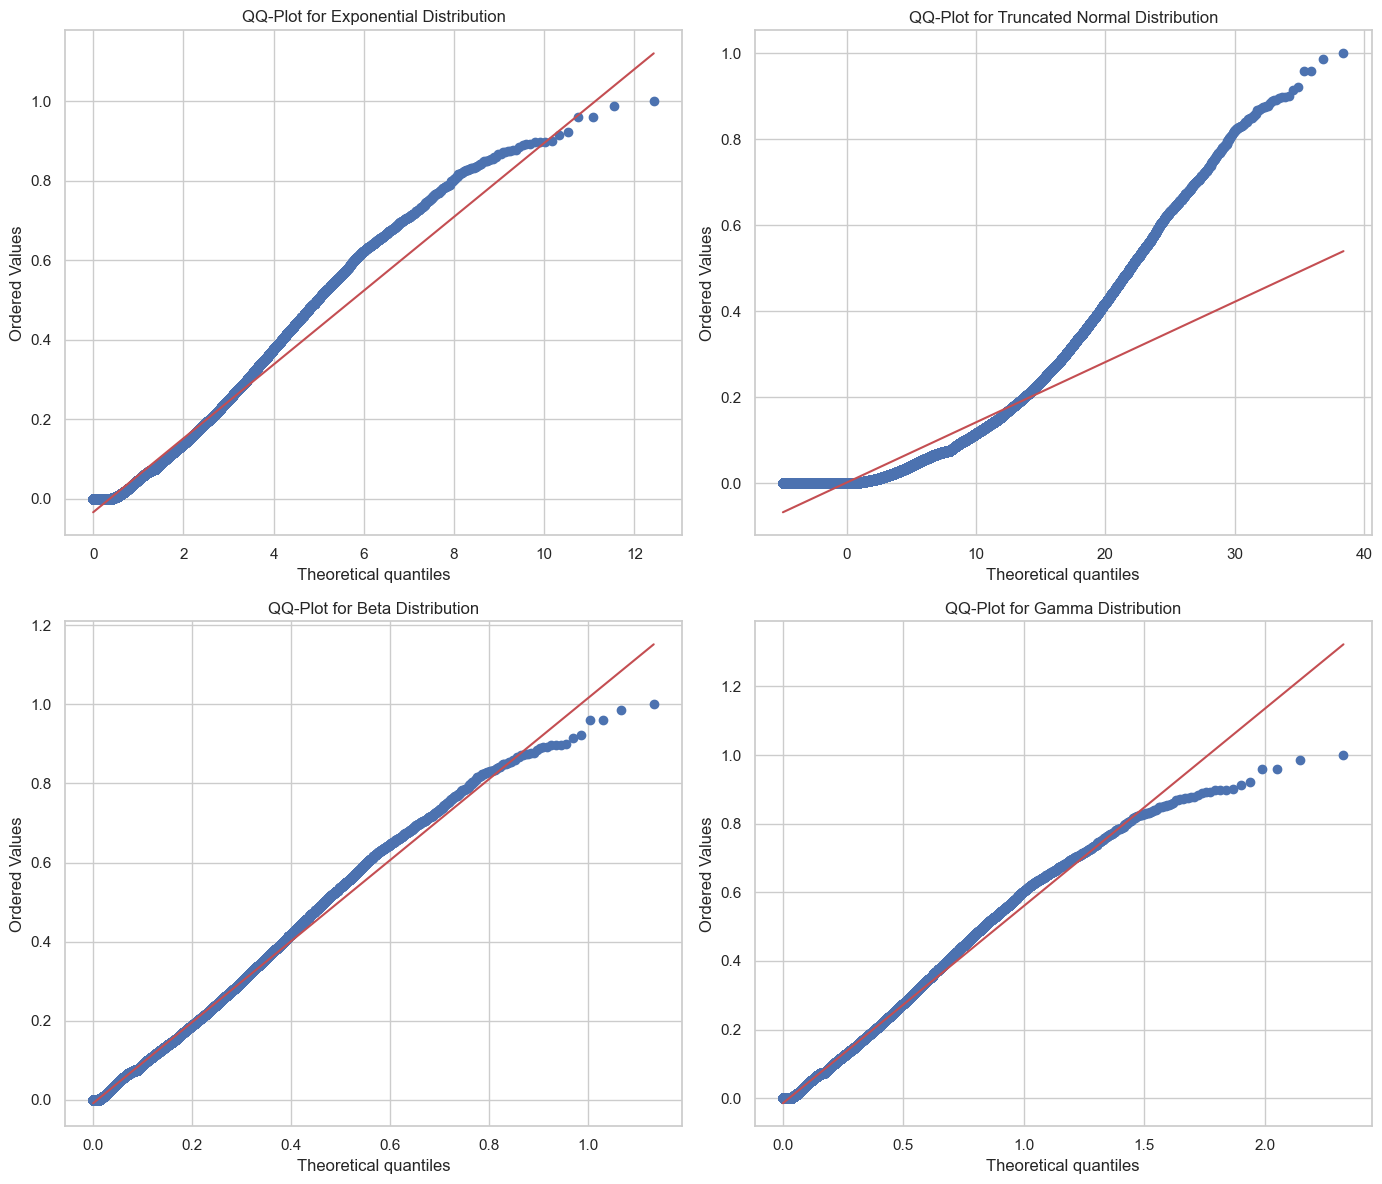

In [19]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Data (you can replace this with your actual diversity scores)
data = list(diversity_scores_distribution.values())

# Scale the data to [0, 1] for fair comparison
data_scaled = (np.array(data) - np.min(data)) / (np.max(data) - np.min(data))

# Plot setup
plt.figure(figsize=(14, 12))

# 1. QQ-Plot for Exponential Distribution
plt.subplot(2, 2, 1)
stats.probplot(data_scaled, dist="expon", plot=plt)
plt.title('QQ-Plot for Exponential Distribution')

# 2. QQ-Plot for Truncated Normal Distribution
a, b = (min(data_scaled) - np.mean(data_scaled)) / np.std(data_scaled), (max(data_scaled) - np.mean(data_scaled)) / np.std(data_scaled)
params_truncnorm = stats.truncnorm.fit(data_scaled, a, b)
plt.subplot(2, 2, 2)
stats.probplot(data_scaled, dist="truncnorm", sparams=(a, b, params_truncnorm[0], params_truncnorm[1]), plot=plt)
plt.title('QQ-Plot for Truncated Normal Distribution')

# 3. QQ-Plot for Beta Distribution
params_beta = stats.beta.fit(data_scaled)  # Fit the Beta distribution
plt.subplot(2, 2, 3)
stats.probplot(data_scaled, dist="beta", sparams=params_beta, plot=plt)
plt.title('QQ-Plot for Beta Distribution')

# 4. QQ-Plot for Gamma Distribution
params_gamma = stats.gamma.fit(data_scaled)  # Fit the Gamma distribution
plt.subplot(2, 2, 4)
stats.probplot(data_scaled, dist="gamma", sparams=params_gamma, plot=plt)
plt.title('QQ-Plot for Gamma Distribution')

# Layout adjustments
plt.tight_layout()
plt.show()


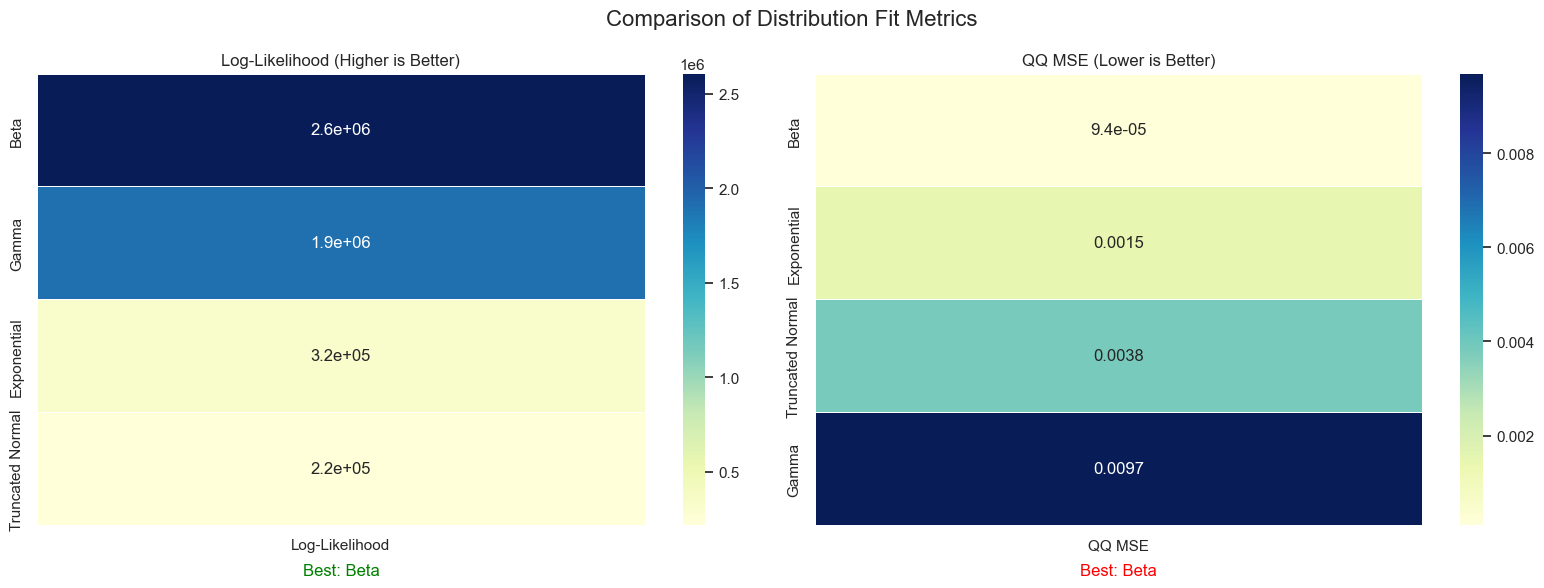

In [20]:

data = np.array(list(diversity_scores_distribution.values()))

def qq_mse(data, theoretical_dist, params=()):
    """Calculate the MSE between observed and theoretical quantiles for a given distribution."""
    quantiles, expected = stats.probplot(data, dist=theoretical_dist, sparams=params)[0]
    mse = np.mean((quantiles - expected) ** 2)
    return mse

def calculate_metrics(data):
    # Normalize the data to [0, 1] range for fair comparison
    data_scaled = (data - np.min(data)) / (np.max(data) - np.min(data))
    
    metrics = {}

    # 1. Exponential Distribution
    params_expon = stats.expon.fit(data_scaled)
    loglik_expon = np.sum(stats.expon.logpdf(data_scaled, *params_expon))
    mse_expon = qq_mse(data_scaled, 'expon', params_expon)
    metrics['Exponential'] = {'Log-Likelihood': loglik_expon, 'QQ MSE': mse_expon}

    # 2. Truncated Normal Distribution
    a, b = (min(data_scaled) - np.mean(data_scaled)) / np.std(data_scaled), (max(data_scaled) - np.mean(data_scaled)) / np.std(data_scaled)
    loc, scale = np.mean(data_scaled), np.std(data_scaled)
    params_truncnorm = (a, b, loc, scale)
    loglik_truncnorm = np.sum(stats.truncnorm.logpdf(data_scaled, a, b, loc, scale))
    mse_truncnorm = qq_mse(data_scaled, 'truncnorm', params_truncnorm)
    metrics['Truncated Normal'] = {'Log-Likelihood': loglik_truncnorm, 'QQ MSE': mse_truncnorm}

    # 3. Beta Distribution (requires scaling data to [0, 1])
    params_beta = stats.beta.fit(data_scaled)
    loglik_beta = np.sum(stats.beta.logpdf(data_scaled, *params_beta))
    mse_beta = qq_mse(data_scaled, 'beta', params_beta)
    metrics['Beta'] = {'Log-Likelihood': loglik_beta, 'QQ MSE': mse_beta}

    # 4. Gamma Distribution
    params_gamma = stats.gamma.fit(data_scaled)
    loglik_gamma = np.sum(stats.gamma.logpdf(data_scaled, *params_gamma))
    mse_gamma = qq_mse(data_scaled, 'gamma', params_gamma)
    metrics['Gamma'] = {'Log-Likelihood': loglik_gamma, 'QQ MSE': mse_gamma}

    return pd.DataFrame(metrics).T

# Calculate the metrics for the data
df_metrics = calculate_metrics(data)

# Sort metrics for each plot
df_metrics_loglik = df_metrics.sort_values(by='Log-Likelihood', ascending=False)
df_metrics_mse = df_metrics.sort_values(by='QQ MSE', ascending=True)

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Heatmap for Log-Likelihood
sns.heatmap(df_metrics_loglik[['Log-Likelihood']], annot=True, cmap='YlGnBu', linewidths=0.5, ax=axes[0])
axes[0].set_title('Log-Likelihood (Higher is Better)')
axes[0].set_ylabel('')
best_loglik_dist = df_metrics_loglik['Log-Likelihood'].idxmax()
axes[0].annotate(f'Best: {best_loglik_dist}', xy=(0.5, -0.1), xycoords='axes fraction',
                 ha='center', va='center', fontsize=12, color='green')

# Plot 2: Heatmap for QQ MSE
sns.heatmap(df_metrics_mse[['QQ MSE']], annot=True, cmap='YlGnBu', linewidths=0.5, ax=axes[1])
axes[1].set_title('QQ MSE (Lower is Better)')
axes[1].set_ylabel('')
best_mse_dist = df_metrics_mse['QQ MSE'].idxmin()
axes[1].annotate(f'Best: {best_mse_dist}', xy=(0.5, -0.1), xycoords='axes fraction',
                 ha='center', va='center', fontsize=12, color='red')

plt.suptitle('Comparison of Distribution Fit Metrics', fontsize=16)
plt.tight_layout()
plt.show()


Given the strong fit of the Beta distribution, we conclude that it is the most likely generative law for the observed diversity scores. This suggests that the diversity of channels in this dataset is best represented by a distribution that allows for flexible modeling of data bounded within a specific range, with varying degrees of skewness and concentration around particular values (small values of diversity in this case).

**AIM** : Divide the space into 3 regions: of low, moderate and high diversity

Find the optimal quantiles using grid search that maximize mean subscribers

In [21]:
import numpy as np
import scipy.stats as stats
import pandas as pd

# Sample data (replace this with your actual data)
data = np.array(list(diversity_scores_distribution.values()))

# Scale data to [0, 1] for Beta distribution
data_scaled = (data - np.min(data)) / (np.max(data) - np.min(data))

# Fit Beta distribution to the scaled data
params_beta = stats.beta.fit(data_scaled)

# Calculate the percentiles for the three regions
low_threshold = stats.beta.ppf(0.1, *params_beta)  # 33rd percentile
print(low_threshold * (np.max(data) - np.min(data))+ + np.min(data))
high_threshold = stats.beta.ppf(0.6, *params_beta)  # 67th percentile
print(high_threshold * (np.max(data) - np.min(data))+ + np.min(data))

# Classify data into three categories
def categorize_diversity(score):
    if score <= low_threshold:
        return 'Low Diversity'
    elif score <= high_threshold:
        return 'Moderate Diversity'
    else:
        return 'High Diversity'

# Apply the categorization to all data points
diversity_categories = [categorize_diversity(score) for score in data_scaled]

# Create a DataFrame for better visualization
df_diversity = pd.DataFrame({
    'Diversity Score': data,
    'Scaled Diversity Score': data_scaled,
    'Category': diversity_categories
})


# Optionally, count the number of channels in each category
category_counts = df_diversity['Category'].value_counts()
print("\nCategory Counts:\n", category_counts)


C:\Users\haoul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning:

invalid value encountered in sqrt



0.010940597969188252
0.612436377761213

Category Counts:
 Category
High Diversity        64492
Low Diversity         61005
Moderate Diversity    48077
Name: count, dtype: int64


In [22]:
channel_data_collection = db_connection.connect_to_mongodb("Channel Data")

Connected to MongoDB at localhost:27017, Database: evollistable, Collection: Channel Data


In [23]:
def retrieve_subscribers_for_categories(channel_categories, collection):
    """
    Retrieves the number of subscribers for channels in each category (low, moderate, high).
    
    Args:
    - channel_categories: A dictionary where keys are 'low', 'moderate', 'high' and values are lists of channel_ids.
    - collection: The MongoDB collection containing channel data with fields `channel_id` and `subscribers`.
    
    Returns:
    - subscribers_dict: A dictionary where keys are 'low', 'moderate', 'high', 
                        and values are lists of subscriber counts corresponding to the channel_ids.
    """
    
    # Initialize dictionary to hold the subscribers count for each category
    subscribers_dict = {'low': [], 'moderate': [], 'high': []}
    
    # Iterate over the categories and their respective channel_ids
    for category, channel_ids in channel_categories.items():
        # Query MongoDB for the subscriber count of the given channel_ids
        pipeline = [
            {"$match": {"channel": {"$in": channel_ids}}},
            {"$project": {"channel": 1, "subscribers_cc": 1}}
        ]
        
        # Fetch data from MongoDB for this category
        result = collection.aggregate(pipeline)
        
        # Extract subscriber counts from the result and append them to the appropriate category
        for doc in result:
            subscribers_dict[category].append(doc['subscribers_cc'])
    
    return subscribers_dict

In [24]:
import numpy as np
import scipy.stats as stats

def categorize_channels_by_diversity(results, low_quantile_order, high_quantile_order):
    """
    Categorize YouTube channels based on diversity scores into low, moderate, and high categories,
    assuming the generative law is Beta distribution.
    
    Parameters:
    - results (dict): A dictionary where keys are channel_ids and values are diversity scores.
    
    Returns:
    - dict: A dictionary with 'low', 'moderate', and 'high' categories, where each category 
            contains a list of channel_ids.
    """
    # Extract the diversity scores from the results dictionary
    diversity_scores = list(results.values())
    
    # Normalize the data to [0, 1] range
    min_value = np.min(diversity_scores)
    max_value = np.max(diversity_scores)
    normalized_data = (diversity_scores - min_value) / (max_value - min_value)
    
    # Fit the Beta distribution to the normalized data
    alpha, beta, loc, scale = stats.beta.fit(normalized_data)  # fit to scaled data
    
    # Compute the quantiles for categorization
    low_quantile = stats.beta.ppf(low_quantile_order, alpha, beta, loc, scale)
    high_quantile = stats.beta.ppf(high_quantile_order, alpha, beta, loc, scale)
    
    # Create the categories dictionary
    categories = {'low': [], 'moderate': [], 'high': []}
    
    # Assign channels to categories based on their normalized diversity scores
    for channel_id, score in results.items():
        # Normalize the score
        normalized_score = (score - min_value) / (max_value - min_value)
        
        # Categorize the channels
        if normalized_score <= low_quantile:
            categories['low'].append(channel_id)
        elif normalized_score <= high_quantile:
            categories['moderate'].append(channel_id)
        else:
            categories['high'].append(channel_id)
    
    return categories

In [31]:
# Retrieve the subscribers for each category
subscribers_dict = retrieve_subscribers_for_categories(categorize_channels_by_diversity(diversity_scores_distribution, 0.1,0.6), channel_data_collection)

# Output the result
print(subscribers_dict)

C:\Users\haoul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning:

invalid value encountered in sqrt



{'low': [42000000, 29500000, 29588818, 27300000, 24800000, 27200000, 26095809, 26000000, 26000000, 19900000, 22900000, 27700000, 19600000, 20289957, 16600000, 17337898, 19200000, 17500000, 18800000, 18712584, 19500000, 18100000, 15600000, 16400000, 16832933, 15000000, 14400000, 15500000, 15903420, 14800000, 14232985, 15300000, 14600000, 15304988, 15300000, 13900000, 14600000, 13983190, 13400000, 13900000, 13300000, 13400000, 7670000, 13900000, 13800000, 12000000, 12500000, 13145196, 13466870, 10000000, 13248988, 7200000, 12500000, 12400000, 12100000, 12100000, 12000000, 11800000, 11300000, 9460000, 11000000, 11500000, 11300000, 10606926, 10707485, 9238019, 8779986, 9630035, 10165801, 10200000, 7040000, 10638666, 9714653, 10300000, 9727097, 9590000, 9980000, 10139227, 9359053, 9930000, 7820000, 8750000, 9730000, 9311270, 8472482, 8090000, 8960000, 8870000, 9270000, 9290000, 8776788, 8540000, 8499078, 7620000, 8640000, 8350000, 7759491, 7880000, 8240000, 7980000, 8590000, 7360000, 805000

PROBLEM : Categories are imbalanced

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_subscribers_comparison_with_boxes(subscribers_dict):
    """
    Plots the comparison of subscriber counts between the three categories (low, moderate, high),
    with a boxplot showing the distributions and no individual points.
    
    Args:
    - subscribers_dict: A dictionary where keys are 'low', 'moderate', 'high', 
                        and values are lists of subscriber counts.
    """
    
    # Convert the dictionary to a pandas DataFrame for easier plotting
    data = []
    for category, subscribers in subscribers_dict.items():
        data.extend(subscribers)
    
    categories = []
    for category, subscribers in subscribers_dict.items():
        categories.extend([category] * len(subscribers))
    
    df = pd.DataFrame({
        'Subscribers': data,
        'Category': categories
    })
    
    # Set the figure size
    plt.figure(figsize=(10, 6))
    
    # Create the boxplot with no individual points or caps
    sns.boxplot(x='Category', y='Subscribers', data=df, palette="Set3", showmeans=False, showcaps=False, showfliers=False)
    
    # Set plot title and labels
    plt.title('Comparison of Subscriber Counts Between Categories')
    plt.xlabel('Diversity Categories')
    plt.ylabel('Number of Subscribers')
    
    # Show the plot
    plt.show()


C:\Users\haoul\AppData\Local\Temp\ipykernel_48048\359731162.py:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




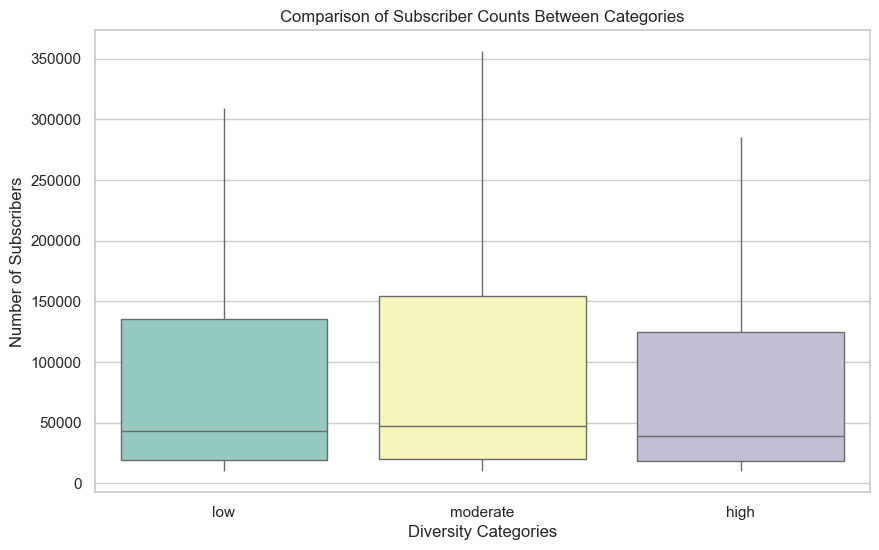

In [27]:
# Plot the comparison
plot_subscribers_comparison_with_boxes(subscribers_dict)

In [28]:
from scipy.stats import mannwhitneyu, kruskal

def compare_subscriber_distributions(subscribers_dict):
    """
    Perform pairwise comparisons between categories using the Kruskal-Wallis test 
    and the Mann-Whitney U test with manual Bonferroni correction.
    
    Parameters:
    - subscribers_dict: A dictionary with three keys ('low', 'moderate', 'high') 
                        containing lists of subscriber counts for each category.
    """
    # Extract subscriber data
    low = subscribers_dict['low']
    moderate = subscribers_dict['moderate']
    high = subscribers_dict['high']
    
    # Step 1: Kruskal-Wallis Test (overall test)
    stat, p_value = kruskal(low, moderate, high)
    print(f"Kruskal-Wallis Test statistic: {stat}, p-value: {p_value}")
    
    if p_value < 0.05:
        print("\nThere is a significant difference between the categories.")
        
        # Step 2: Pairwise Mann-Whitney U Tests
        comparisons = [
            ('low', 'moderate', low, moderate),
            ('low', 'high', low, high),
            ('moderate', 'high', moderate, high)
        ]
        
        p_values = []
        results = []
        
        print("\nPerforming pairwise Mann-Whitney U tests:")
        for name1, name2, group1, group2 in comparisons:
            stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
            p_values.append(p)
            results.append((name1, name2, stat, p))
        
        # Step 3: Manual Bonferroni Correction
        num_comparisons = len(comparisons)
        corrected_p_values = [min(p * num_comparisons, 1.0) for p in p_values]  # Bonferroni correction
        
        # Display the results
        print("\nPairwise comparisons with Bonferroni correction:")
        for (name1, name2, stat, original_p), corrected_p in zip(results, corrected_p_values):
            print(f"Comparison: {name1} vs {name2}")
            print(f"  Mann-Whitney U statistic: {stat}, Original p-value: {original_p}, Corrected p-value: {corrected_p}")
            if corrected_p < 0.05:
                print("  Significant difference between groups.\n")
            else:
                print("  No significant difference between groups.\n")
    else:
        print("No significant difference between the categories.")

In [29]:
compare_subscriber_distributions(subscribers_dict)

Kruskal-Wallis Test statistic: 310.85234368643364, p-value: 3.156975599017611e-68

There is a significant difference between the categories.

Performing pairwise Mann-Whitney U tests:

Pairwise comparisons with Bonferroni correction:
Comparison: low vs moderate
  Mann-Whitney U statistic: 804346701.0, Original p-value: 5.0161500340503645e-18, Corrected p-value: 1.5048450102151094e-17
  Significant difference between groups.

Comparison: low vs high
  Mann-Whitney U statistic: 1140711960.0, Original p-value: 7.237358189751687e-17, Corrected p-value: 2.1712074569255058e-16
  Significant difference between groups.

Comparison: moderate vs high
  Mann-Whitney U statistic: 1206832607.5, Original p-value: 3.9207767057085684e-69, Corrected p-value: 1.1762330117125705e-68
  Significant difference between groups.



**Is there correlation, causality?**

C:\Users\haoul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning:

invalid value encountered in sqrt



Best Quantiles Found: q1 = 0.05, q2 = 0.6, Mean Subscribers = 281665.5641787497


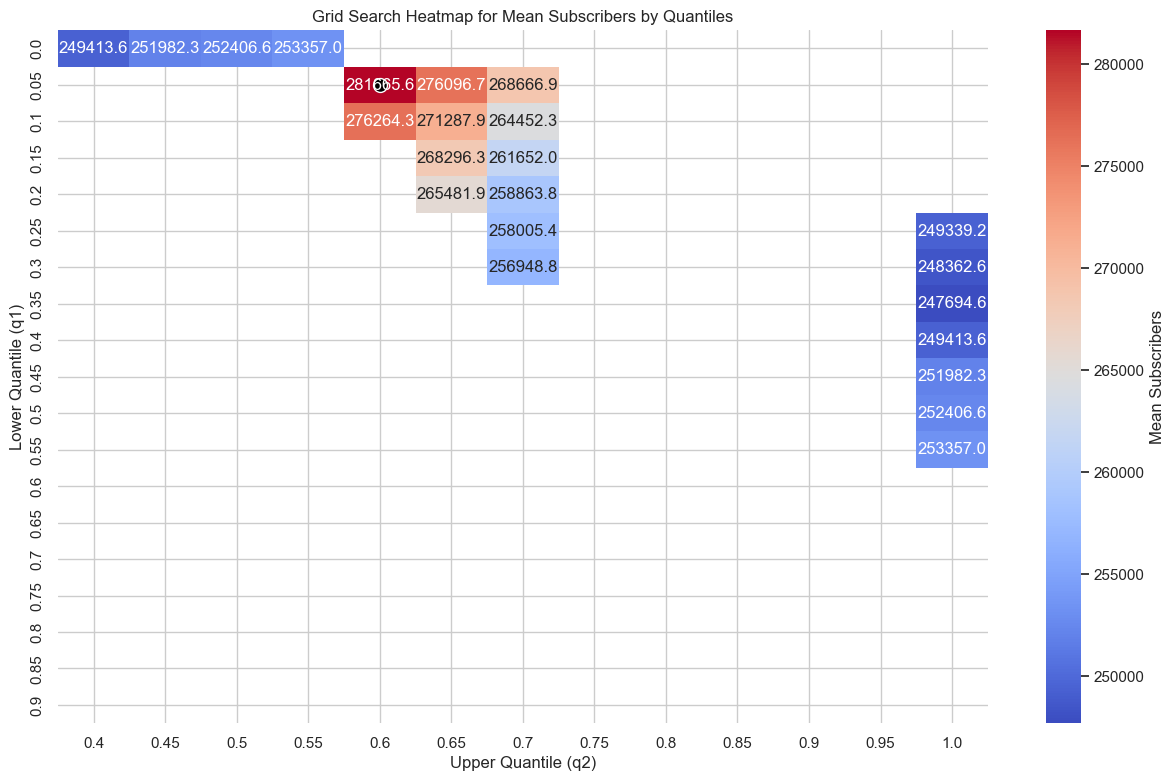

In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_grid_search(results, collection, q1_range, q2_range, min_balance=0.3):
    """
    Visualize the results of the grid search as a heatmap.
    
    Parameters:
    - results: The dictionary of diversity scores per channel.
    - collection: The MongoDB collection to fetch subscriber data.
    - q1_range: List or numpy array of quantiles for the lower boundary.
    - q2_range: List or numpy array of quantiles for the upper boundary.
    - min_balance: Minimum proportion of channels required in each category.
    """
    heatmap_data = np.full((len(q1_range), len(q2_range)), np.nan)
    n_total = len(results)
    best_q1, best_q2 = None, None
    best_mean_subscribers = -np.inf

    for i, q1 in enumerate(q1_range):
        for j, q2 in enumerate(q2_range):
            if q2 <= q1:
                continue

            # Special case: if q1 == 0, use two categories
            if q1 == 0:
                categories = categorize_channels_by_diversity(results, q1, q2)
                size_low = len(categories['moderate'])
                size_high = len(categories['high'])
                new_min_balance = 0.4

                if size_low / n_total >= new_min_balance and size_high / n_total >= new_min_balance:
                    subscribers_dict = retrieve_subscribers_for_categories(categories, collection)
                    mean_subscribers_moderate = np.mean(subscribers_dict['moderate']) if subscribers_dict['moderate'] else 0
                    mean_subscribers_high = np.mean(subscribers_dict['high']) if subscribers_dict['high'] else 0
                    max_mean_subscribers = max(mean_subscribers_moderate, mean_subscribers_high)
                    
                    heatmap_data[i, j] = max_mean_subscribers

                    if max_mean_subscribers > best_mean_subscribers:
                        best_mean_subscribers = max_mean_subscribers
                        best_q1, best_q2 = q1, q2
            
            if q2 == 1:
                categories = categorize_channels_by_diversity(results, q1, q2)
                size_low = len(categories['low'])
                size_moderate = len(categories['moderate'])
                new_min_balance = 0.4

                if size_low / n_total >= new_min_balance and size_moderate / n_total >= new_min_balance:
                    subscribers_dict = retrieve_subscribers_for_categories(categories, collection)
                    mean_subscribers_low = np.mean(subscribers_dict['low']) if subscribers_dict['low'] else 0
                    mean_subscribers_moderate = np.mean(subscribers_dict['moderate']) if subscribers_dict['moderate'] else 0
                    max_mean_subscribers = max(mean_subscribers_low, mean_subscribers_moderate)
                    
                    heatmap_data[i, j] = max_mean_subscribers

                    if max_mean_subscribers > best_mean_subscribers:
                        best_mean_subscribers = max_mean_subscribers
                        best_q1, best_q2 = q1, q2
            
            else:
                # Handle three-category case
                categories = categorize_channels_by_diversity(results, q1, q2)
                size_low = len(categories['low'])
                size_moderate = len(categories['moderate'])
                size_high = len(categories['high'])

                if (size_low / n_total >= min_balance and
                    size_moderate / n_total >= min_balance and
                    size_high / n_total >= min_balance):
                    
                    subscribers_dict = retrieve_subscribers_for_categories(categories, collection)
                    if subscribers_dict['moderate']:
                        mean_subscribers_moderate = np.mean(subscribers_dict['moderate'])
                        heatmap_data[i, j] = mean_subscribers_moderate

                        if mean_subscribers_moderate > best_mean_subscribers:
                            best_mean_subscribers = mean_subscribers_moderate
                            best_q1, best_q2 = q1, q2

    print(f"Best Quantiles Found: q1 = {best_q1}, q2 = {best_q2}, Mean Subscribers = {best_mean_subscribers}")
    
    # Plotting the heatmap
    plt.figure(figsize=(15, 9))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", 
                xticklabels=np.round(q2_range, 2), yticklabels=np.round(q1_range, 2),
                cbar_kws={'label': 'Mean Subscribers'})
    
    plt.title("Grid Search Heatmap for Mean Subscribers by Quantiles")
    plt.xlabel("Upper Quantile (q2)")
    plt.ylabel("Lower Quantile (q1)")
    
    # Highlight the optimal point
    if best_q1 is not None and best_q2 is not None:
        optimal_i = np.where(q1_range == best_q1)[0][0]
        optimal_j = np.where(q2_range == best_q2)[0][0]
        plt.scatter(optimal_j + 0.5, optimal_i + 0.5, color='black', s=100, edgecolors='white', marker='o')
        #plt.text(optimal_j + 0.5, optimal_i + 0.5, 'Optimal', color='black',
        #         ha='center', va='center', weight='bold')

    plt.show()


# Define the range of quantiles to test
q1_range = np.linspace(0, 0.9, 19)
q2_range = np.linspace(0.4, 1.0, 13)

# Visualize the grid search results with debugging information
visualize_grid_search(diversity_scores_distribution, channel_data_collection, q1_range, q2_range, min_balance=0.27)


IDEAS

Existe-il un temps transitoire pour que le reach d'une chaine augmente après une ouverture sur une nouvelle catégorie?

* Build a recommendation system for content creators. Imagine the diversity score of a channel is 1, and the optimal range that maximizes the reach is [2,3] then we recommend a category that would boost his score and put him in the optimal range.
*Inspect the notion of direct competition. The more diverse a channel is, the less direct competitors it has. We can predict the number of competitors given 
* Are there channels that mischose their categories (the most occurrent category is not the main category of the channel). Is this mischoice correlated with the performance of the channel?

Comparison between the typical evolution of a channel of the cluster (gaming, music...) with education, howto&style..